# **Notebook 02 -- Spatial Sampling: Presences and Pseudo-Absences**

## Predictive Archaeological Modelling -- Peru (v2)
**Author:** Yishar Piero Nieto Barrientos

---

### Objective

Generate the **spatial sample dataset** for supervised learning: positive archaeological locations ($Y=1$) from declared sites and delimited zones, and pseudo-absence coordinates ($Y=0$) via uniform random sampling within Peru's boundary.

### Pipeline

| Step | Description | Output |
|------|-------------|--------|
| 1 | Environment setup and raster inventory | -- |
| 2 | Presence extraction (declared sites + zone pixels) | `presencias.csv` |
| 3 | Pseudo-absence generation (target shooting) | `ausencias.csv` |
| 4 | Spatial distribution map | Figure |

### Technical Specifications

| Parameter | Value |
|---|---|
| Spatial resolution | 30 x 30 m per pixel |
| Coordinate Reference System | ESRI:102033 (South America Albers Equal Area Conic) |
| DEM source | ASTER GDEM v3 |

**Depends on:** Notebook 01 (all rasters validated).
**Next:** Notebook 03 (Feature Engineering / Pixel Drilling).

### **1. Environment Setup**

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio

from shapely.geometry import Point
from shapely.prepared import prep
from tqdm import tqdm

from src.config import (
    RASTER_DIR, SAMPLES_DIR, RAW_DIR,
    figures_dir, get_raster_paths,
)

%matplotlib inline
sns.set_style("whitegrid")

FIGURES_DIR = figures_dir("02_sampling")

print("Environment configured.")

Environment configured.


### **2. Variable Inventory**

All 15 predictor layers (validated in NB01) that will be sampled in NB03 via pixel drilling. This cell confirms file availability before generating coordinates.

| Domain | Variable | Type | Ver | Archaeological Hypothesis |
| :--- | :--- | :--- | :---: | :--- |
| **Terrain** | Slope | continuous | v1 | Flat terrain preferred for habitation and agriculture. |
| **Terrain** | Ruggedness (TRI) | continuous | v1 | Less rugged areas facilitate mobility and construction. |
| **Terrain** | Elevation | continuous | v2 | Altitude determines ecological zones and habitability. |
| **Terrain** | Slope Aspect | continuous | v2 | North-facing slopes receive more sunlight in southern hemisphere. |
| **Terrain** | Profile Curvature | continuous | v2 | Concavity/convexity affects water flow and erosion. |
| **Terrain** | Topographic Position Index | continuous | v2 | Relative elevation: ridges vs valleys. |
| **Terrain** | Topographic Wetness Index | continuous | v2 | Soil moisture proxy -- flat, low-gradient areas. |
| **Hydrography** | Dist. Rivers | distance | v1 | Water access is the fundamental predictor of habitability. |
| **Hydrography** | Dist. Lakes | distance | v1 | Aquatic resources and ritual significance. |
| **Road Network** | Dist. Qhapaq Nan | distance | v1 | Connectivity increases probability of administrative settlements. |
| **Context** | Dist. Declared Sites | distance | v1 | Clustering effect near known locations. |
| **Context** | Dist. Monumental Nuclei (G1) | distance | v1 | Direct influence of major urban/ceremonial centres. |
| **Context** | Dist. Cultural Landscapes (G2) | distance | v1 | Relationship with extensive modification areas (terraces, canals). |
| **Context** | Dist. Isolated Evidence (G3) | distance | v1 | Spatial continuity of isolated findings. |
| **Ecological** | Pisos Ecologicos | categorical | v2 | Altitudinal classification -- each zone has distinct resources. |

In [ ]:
# -- Quick raster inventory (from config registry) ----------------------------
from src.config import get_rasters

all_vars = get_rasters()
all_rasters = get_raster_paths()

print(f"--- Raster Inventory: {len(all_vars)} variables ---")
for rv in all_vars:
    if rv.exists:
        print(f"  [OK]      {rv.version}  {rv.name:<25s} {rv.var_type.value}")
    else:
        print(f"  [MISSING] {rv.version}  {rv.name:<25s} {rv.path}")

--- Geospatial Data Inventory ---
  [OK] pendiente                 | 30.0 m | CRS: ESRI:102033
  [OK] rugosidad                 | 30.0 m | CRS: ESRI:102033
  [OK] distancia_rios            | 30.0 m | CRS: ESRI:102033
  [OK] distancia_lagos           | 30.0 m | CRS: ESRI:102033
  [OK] distancia_qhapaq_nan      | 30.0 m | CRS: ESRI:102033
  [OK] distancia_declarados      | 30.0 m | CRS: ESRI:102033
  [OK] distancia_g1              | 30.0 m | CRS: ESRI:102033
  [OK] distancia_g2              | 30.0 m | CRS: ESRI:102033
  [OK] distancia_g3              | 30.0 m | CRS: ESRI:102033


### **3. Presence Sampling ($Y = 1$)**

The positive class is constructed by integrating point records and inverse-vectorized zonation surfaces. To handle spatial imbalance between large monumental complexes and isolated finds, a **stratified random sampling** protocol is applied:

1. **Hybrid data source:**
    * **Declared Sites (Points):** All registered centroids ($N_{\text{total}}$).
    * **Delimited Areas (Zones G1, G2, G3):** Pixels with value $= 0$ in Euclidean distance rasters, representing the interior of original delimitation polygons.

2. **Quota Sampling:**
    To mitigate *area bias* (where extensive sites like Chan Chan could dominate the training sample), maximum extraction quotas are set per category:
    * **Zone G1 (Monumental):** Dense sampling (limit: 5,000 random pixels).
    * **Zone G2 (Cultural Landscape):** Medium sampling (limit: 3,000 pixels).
    * **Zone G3 (Isolated Evidence):** Targeted sampling (limit: 1,000 pixels).

3. **Spatial Validation:**
    All extracted coordinates are snapped to the 30 m grid and spatially deduplicated, ensuring each observation corresponds to a unique minimum analysis unit.

In [6]:
# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
ruta_puntos_shp = os.path.join(RAW_DIR, "declarados", "declarados.shp")

rasters_zonas = {
    "G1": os.path.join(RASTER_DIR, "distancia_g1.tif"),
    "G2": os.path.join(RASTER_DIR, "distancia_g2.tif"),
    "G3": os.path.join(RASTER_DIR, "distancia_g3.tif"),
}

cuotas_muestreo = {"G1": 5000, "G2": 3000, "G3": 1000}
lista_dataframes = []

# ==============================================================================
# 2. DECLARED SITES (POINT SHAPEFILE)
# ==============================================================================
print("--- Step 1: Processing declared sites (SHP) ---")
if os.path.exists(ruta_puntos_shp):
    gdf = gpd.read_file(ruta_puntos_shp)
    if gdf.crs != "ESRI:102033":
        gdf = gdf.to_crs("ESRI:102033")

    df_pt = pd.DataFrame({
        "X_102033": gdf.geometry.x,
        "Y_102033": gdf.geometry.y,
        "Origen": "Sitio_Declarado",
        "Target": 1,
    })
    lista_dataframes.append(df_pt)
    print(f"  Added {len(df_pt)} declared sites.")
else:
    print(f"  WARNING: Not found: {ruta_puntos_shp}")

# ==============================================================================
# 3. ZONE EXTRACTION FROM DISTANCE RASTERS
# ==============================================================================
print("\n--- Step 2: Extracting zone pixels from distance rasters ---")

for zona, ruta in rasters_zonas.items():
    if not os.path.exists(ruta):
        print(f"  [SKIP] {zona}: file not found.")
        continue

    print(f"  Scanning {zona} ...")
    coord_temp = []

    with rasterio.open(ruta) as src:
        for ji, window in tqdm(list(src.block_windows(1)), desc=f"  {zona}"):
            data = src.read(1, window=window)
            mask = (data >= 0) & (data < 1.0)
            if np.any(mask):
                rows, cols = np.where(mask)
                xs, ys = src.xy(rows + window.row_off, cols + window.col_off)
                coord_temp.extend(list(zip(xs, ys)))

    total = len(coord_temp)
    cuota = cuotas_muestreo.get(zona, 1000)

    df_zona = pd.DataFrame(coord_temp, columns=["X_102033", "Y_102033"])
    if total > cuota:
        df_zona = df_zona.sample(n=cuota, random_state=42)
        print(f"  {zona}: {total} pixels found -> sampled to {cuota}")
    else:
        print(f"  {zona}: {total} pixels found -> kept all")

    df_zona["Origen"] = f"Zona_{zona}"
    df_zona["Target"] = 1
    lista_dataframes.append(df_zona)

# ==============================================================================
# 4. MERGE AND SPATIAL DEDUPLICATION
# ==============================================================================
print("\n--- Step 3: Merging and deduplicating ---")
if lista_dataframes:
    df_final = pd.concat(lista_dataframes, ignore_index=True)

    df_final["x_snap"] = (df_final["X_102033"] // 30) * 30
    df_final["y_snap"] = (df_final["Y_102033"] // 30) * 30

    n_before = len(df_final)
    df_final = df_final.drop_duplicates(subset=["x_snap", "y_snap"])
    n_after = len(df_final)

    df_export = df_final[["X_102033", "Y_102033", "Origen", "Target"]]

    ruta_salida = os.path.join(SAMPLES_DIR, "presencias.csv")
    df_export.to_csv(ruta_salida, index=False)

    print(f"  Before dedup: {n_before} | After: {n_after}")
    print(f"  Saved: {ruta_salida}")
    print(f"\n  Distribution by origin:")
    print(df_export["Origen"].value_counts().to_string())
else:
    print("  ERROR: No data generated.")

--- Step 1: Processing declared sites (SHP) ---
  Added 5890 declared sites.

--- Step 2: Extracting zone pixels from distance rasters ---
  Scanning G1 ...


  G1: 100%|██████████| 73649/73649 [01:16<00:00, 958.93it/s] 


  G1: 8274226 pixels found -> sampled to 5000
  Scanning G2 ...


  G2: 100%|██████████| 73649/73649 [01:16<00:00, 966.93it/s] 


  G2: 11851141 pixels found -> sampled to 3000
  Scanning G3 ...


  G3: 100%|██████████| 73649/73649 [01:02<00:00, 1179.62it/s]


  G3: 1318 pixels found -> sampled to 1000

--- Step 3: Merging and deduplicating ---
  Before dedup: 14890 | After: 14786
  Saved: ../data/processed/samples/presencias.csv

  Distribution by origin:
Origen
Sitio_Declarado    5786
Zona_G1            5000
Zona_G2            3000
Zona_G3            1000


### **4. Pseudo-absence Generation ($Y = 0$)**

To mitigate the inherent bias of *Presence-Only* records, **pseudo-absences** are generated via uniform spatial random sampling within the national boundary.

1. **Sampling frame:** Peru's official administrative boundary projected to ESRI:102033.
2. **Generation algorithm (Target Shooting):** Random coordinates $(x, y)$ drawn from a uniform distribution within the bounding box, validated in two stages:
    * **Geometric validation:** Only points strictly inside Peru's polygon are retained.
    * **Exclusion filter:** Points coinciding spatially (on the 30 x 30 m grid) with confirmed archaeological sites ($Y=1$) are discarded, ensuring class independence.
3. **Class balance:** The iterative process stops upon reaching a **1:1 ratio** with respect to the presence set ($N_{\text{absences}} = N_{\text{presences}}$).

In [7]:
# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
ruta_presencias = os.path.join(SAMPLES_DIR, "presencias.csv")
ruta_mask = os.path.join(RASTER_DIR, "pendiente.tif")

if not os.path.exists(ruta_mask):
    raise FileNotFoundError(f"Mask raster not found: {ruta_mask}")

print("--- 1. Loading presence data ---")
df_si = pd.read_csv(ruta_presencias)
n_objetivo = len(df_si)
print(f"  Target: {n_objetivo} pseudo-absence points (1:1 ratio).")

# Blacklist set (snapped to 30 m grid)
set_presencias = set(zip(
    (pd.to_numeric(df_si["X_102033"], errors="coerce") // 30).fillna(0).astype(int) * 30,
    (pd.to_numeric(df_si["Y_102033"], errors="coerce") // 30).fillna(0).astype(int) * 30,
))

# ==============================================================================
# 2. LOAD PERU BOUNDARY
# ==============================================================================
print("--- 2. Loading country boundary ---")
url_mapa = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url_mapa)
peru_gdf = world[world["ADMIN"] == "Peru"].to_crs("ESRI:102033")
peru_geom = peru_gdf.geometry.values[0]
peru_optimizado = prep(peru_geom)

minx, miny, maxx, maxy = peru_gdf.total_bounds

# ==============================================================================
# 3. RANDOM SPATIAL SAMPLING (Target Shooting)
# ==============================================================================
ausencias_validas = []
batch_size = 50000
pbar = tqdm(total=n_objetivo, desc="  Generating")

print("--- 3. Generating pseudo-absence coordinates ---")

with rasterio.open(ruta_mask) as src:
    while len(ausencias_validas) < n_objetivo:
        x_rand = np.random.uniform(minx, maxx, batch_size)
        y_rand = np.random.uniform(miny, maxy, batch_size)

        candidatos = []
        coords_to_sample = list(zip(x_rand, y_rand))
        for (x, y), val in zip(coords_to_sample, src.sample(coords_to_sample)):
            if val[0] != src.nodata:
                candidatos.append((x, y))

        for x, y in candidatos:
            if len(ausencias_validas) >= n_objetivo:
                break
            if peru_optimizado.contains(Point(x, y)):
                x_grid = int(x // 30) * 30
                y_grid = int(y // 30) * 30
                if (x_grid, y_grid) not in set_presencias:
                    ausencias_validas.append({"X_102033": x, "Y_102033": y})
                    pbar.update(1)

pbar.close()

# ==============================================================================
# 4. SAVE
# ==============================================================================
df_out = pd.DataFrame(ausencias_validas)
df_out["Origen"] = "Pseudo_Ausencia"
df_out["Target"] = 0

ruta_salida = os.path.join(SAMPLES_DIR, "ausencias.csv")
df_out.to_csv(ruta_salida, index=False)

print(f"\n  Generated {len(df_out)} pseudo-absence points.")
print(f"  Saved: {ruta_salida}")

--- 1. Loading presence data ---
  Target: 14786 pseudo-absence points (1:1 ratio).
--- 2. Loading country boundary ---


  Generating:   0%|          | 0/14786 [00:00<?, ?it/s]

--- 3. Generating pseudo-absence coordinates ---


  Generating: 100%|██████████| 14786/14786 [01:42<00:00, 143.96it/s]



  Generated 14786 pseudo-absence points.
  Saved: ../data/processed/samples/ausencias.csv


### **5. Spatial Distribution Map**

Spatial distribution of training samples. Red points ($Y=1$) represent positive archaeological evidence (declared sites and zone-sampled pixels). Blue points ($Y=0$) represent pseudo-absences generated uniformly within Peru's national boundary, excluding known archaeological zones. Orange polygons indicate officially delimited archaeological areas.

Preparing spatial visualization ...


/tmp/ipykernel_16551/2980687764.py:58: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  leg = ax.legend(loc="lower left", frameon=True, fontsize=11, markerscale=6)


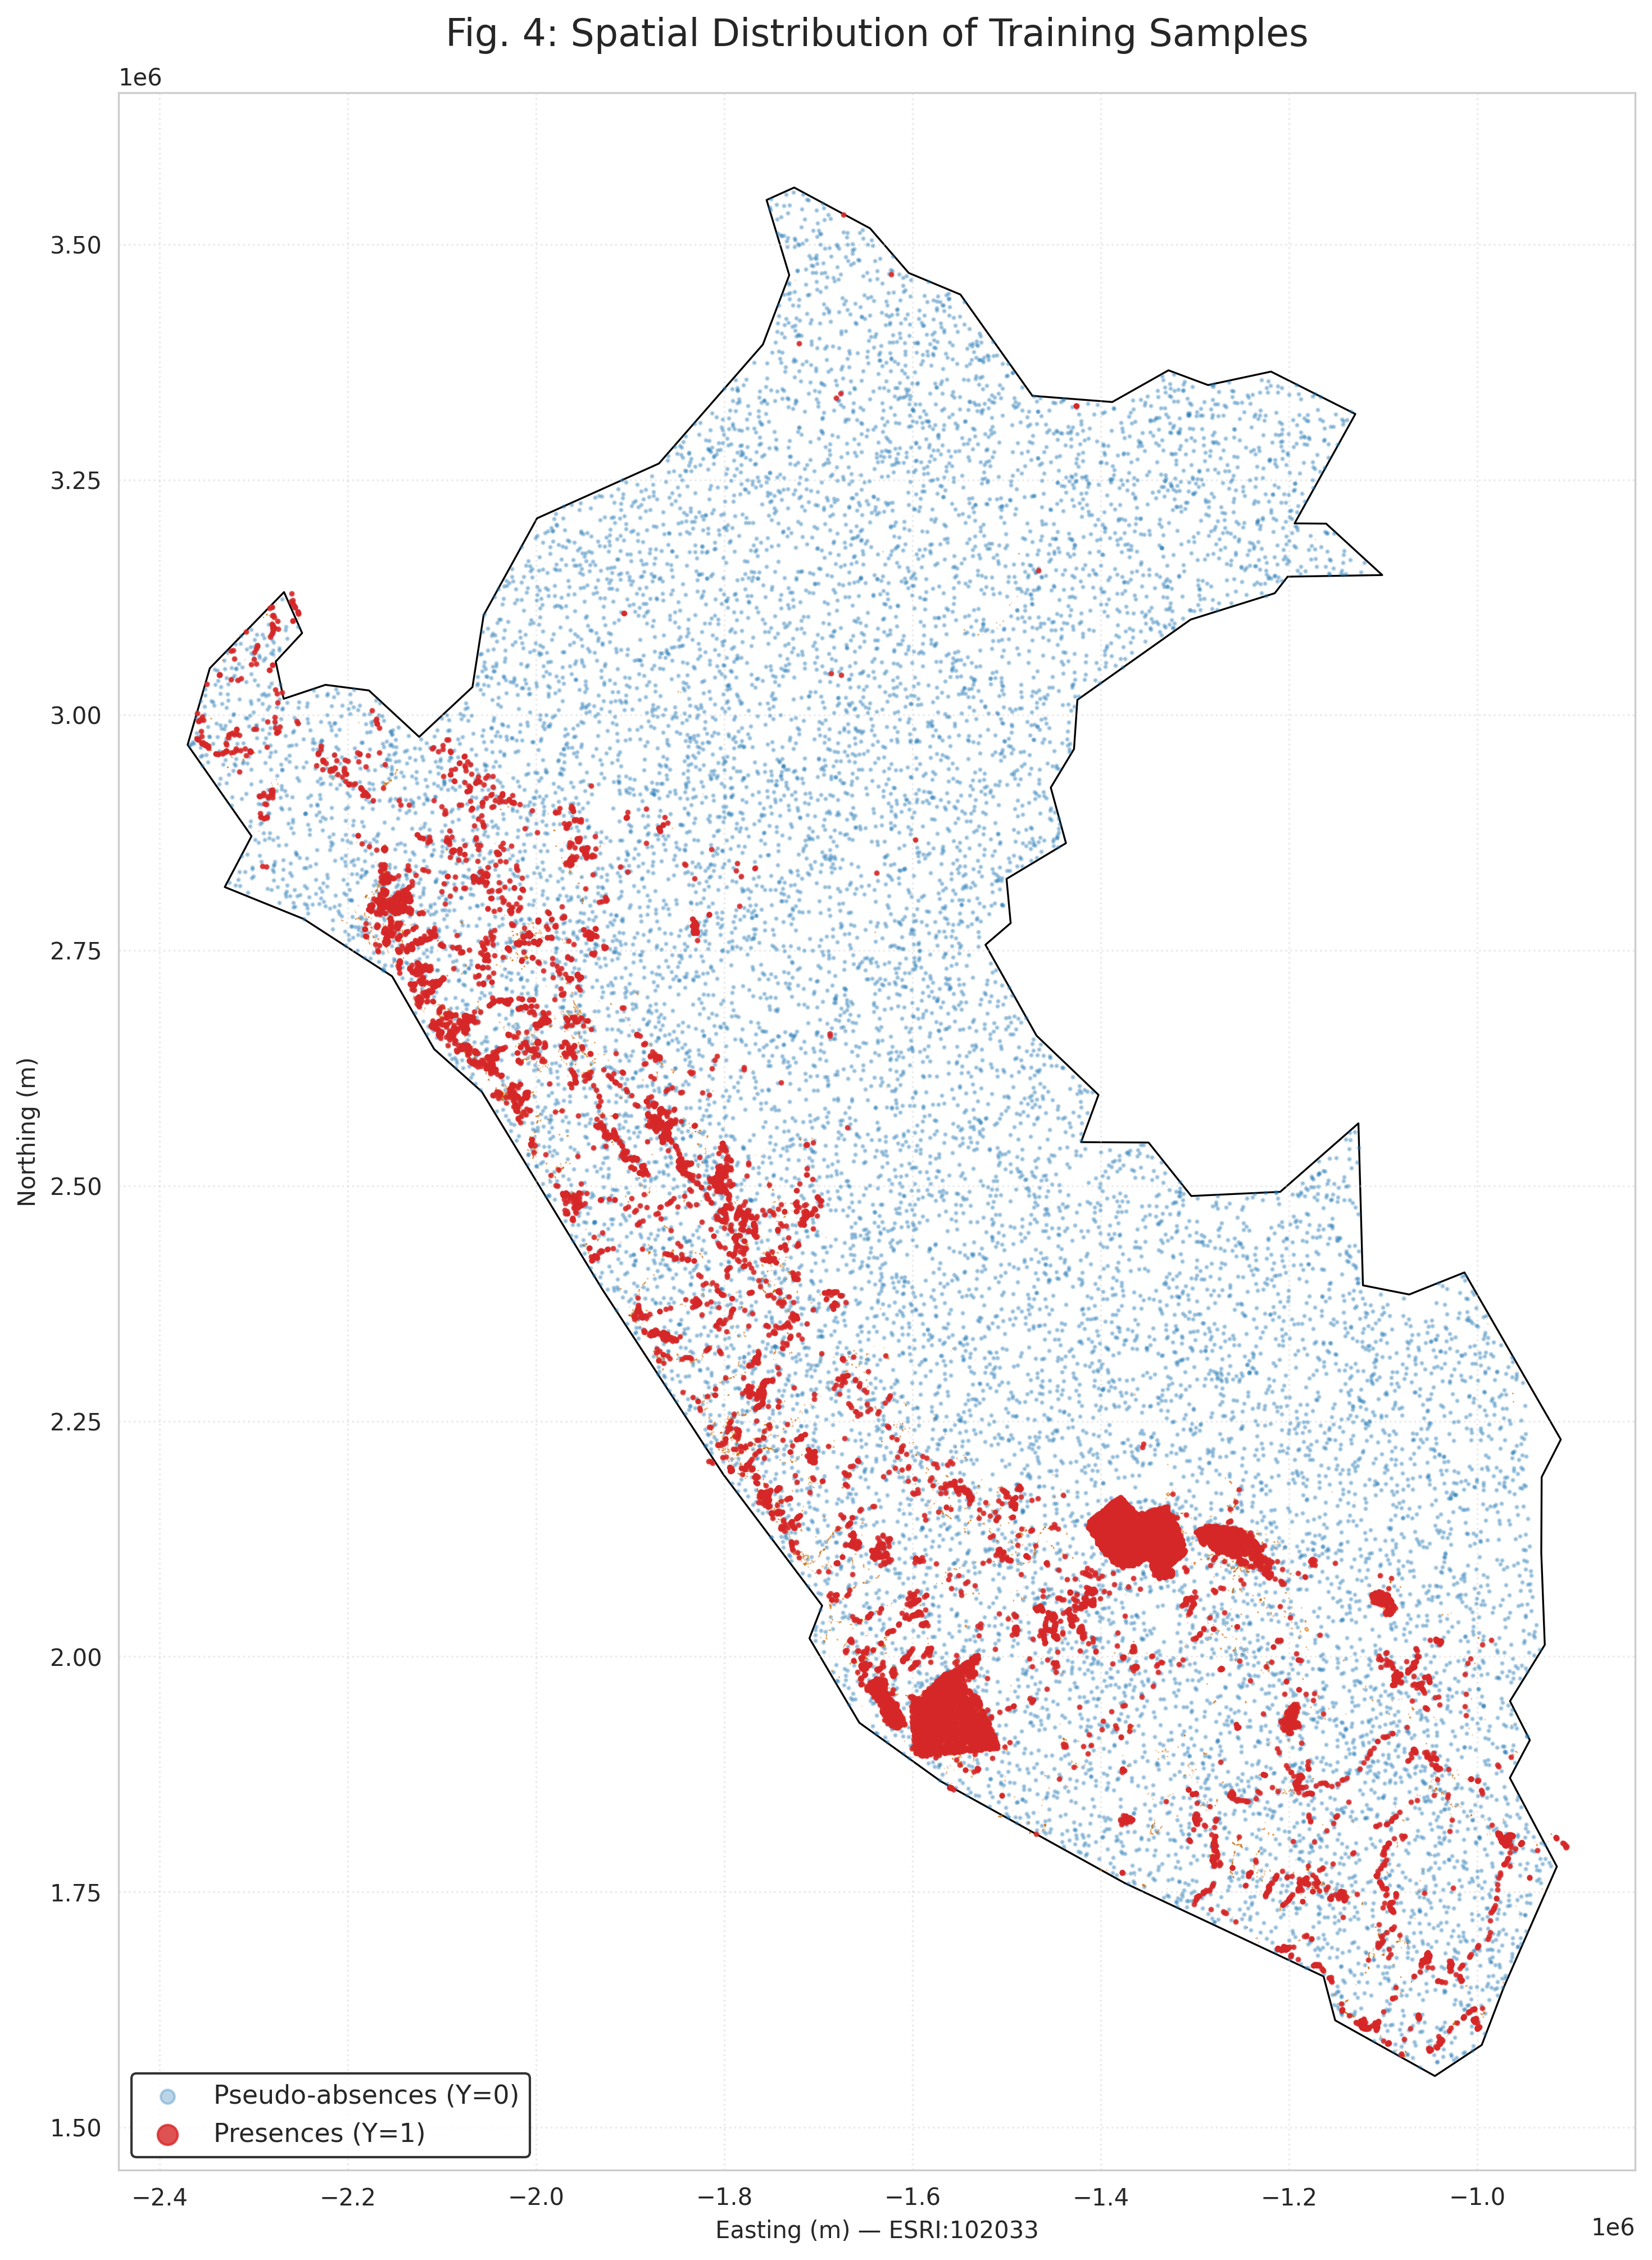

Figure saved: ../outputs/figures/nb01_preprocessing/fig_training_distribution.png


In [ ]:
# ==============================================================================
# 1. LOAD DATA
# ==============================================================================
ruta_delimitados = os.path.join(RAW_DIR, "delimitados", "delimitados.shp")
ruta_si = os.path.join(SAMPLES_DIR, "presencias.csv")
ruta_no = os.path.join(SAMPLES_DIR, "ausencias.csv")

print("Preparing spatial visualization ...")

df_si = pd.read_csv(ruta_si)
df_no = pd.read_csv(ruta_no)

gdf_si = gpd.GeoDataFrame(
    df_si, geometry=gpd.points_from_xy(df_si.X_102033, df_si.Y_102033), crs="ESRI:102033"
)
gdf_no = gpd.GeoDataFrame(
    df_no, geometry=gpd.points_from_xy(df_no.X_102033, df_no.Y_102033), crs="ESRI:102033"
)

gdf_delimitados = None
if os.path.exists(ruta_delimitados):
    gdf_delimitados = gpd.read_file(ruta_delimitados)
    if gdf_delimitados.crs != "ESRI:102033":
        gdf_delimitados = gdf_delimitados.to_crs("ESRI:102033")

# Peru border
try:
    url_mapa = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url_mapa)
    peru_borde = world[world["ADMIN"] == "Peru"].to_crs("ESRI:102033")
except Exception:
    peru_borde = None

# ==============================================================================
# 2. PLOT
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 16), dpi=300)

if peru_borde is not None:
    peru_borde.plot(ax=ax, color="white", edgecolor="black", linewidth=0.8, zorder=0)

if gdf_delimitados is not None:
    gdf_delimitados.plot(
        ax=ax, color="#ff7f0e", edgecolor="#cc6600",
        linewidth=0.5, alpha=0.5,
        label="Delimited zones (polygons)", zorder=2,
    )

gdf_no.plot(ax=ax, markersize=1, color="#1f77b4", alpha=0.3,
            label="Pseudo-absences (Y=0)", zorder=1)
gdf_si.plot(ax=ax, markersize=2, color="#d62728", alpha=0.8,
            label="Presences (Y=1)", zorder=3)

ax.set_title("Fig. 1: Spatial Distribution of Training Samples", fontsize=16, pad=20)
ax.set_xlabel("Easting (m) -- ESRI:102033", fontsize=10)
ax.set_ylabel("Northing (m)", fontsize=10)

leg = ax.legend(loc="lower left", frameon=True, fontsize=11, markerscale=6)
leg.get_frame().set_edgecolor("black")
ax.grid(True, linestyle=":", alpha=0.4)
ax.set_aspect("equal")

fig.savefig(os.path.join(FIGURES_DIR, "fig_training_distribution.png"), bbox_inches="tight", dpi=300)
plt.show()
print(f"Saved: {FIGURES_DIR}/fig_training_distribution.png")